In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import gaussian_kde

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
X = df_train.drop(columns=['strength'])
y = df_train['strength']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
class CVAE(nn.Module):
    def __init__(self, x_dim, cond_dim=1, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(x_dim + cond_dim, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 32),
            nn.ReLU(),
            nn.Linear(32, x_dim)
        )

    def encode(self, x, c):
        xc = torch.cat([x, c], dim=1)
        h = self.encoder(xc)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        zc = torch.cat([z, c], dim=1)
        return self.decoder(zc)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [6]:
def loss_function(x_recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [7]:
x_dim = X.shape[1]
model = CVAE(x_dim=x_dim, cond_dim=1, latent_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 250
last_values = [0] + [1] * 5
threshold = 0.002

for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch, y_batch.unsqueeze(1))
        loss = loss_function(x_recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        last_values[epoch%len(last_values)] = total_loss
    
    absolute_errors = [abs(x - max(last_values)) for x in last_values]
    mae = sum(absolute_errors) / len(absolute_errors)
    if mae < threshold:
        print(f"Early stopping at epoch {epoch} with MAE: {mae:.4f}")
        break

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 188.8765
Epoch 1, Loss: 43.2282
Epoch 2, Loss: 12.2935
Epoch 3, Loss: 5.2051
Epoch 4, Loss: 2.0377
Epoch 5, Loss: 1.5434
Epoch 6, Loss: 1.3777
Epoch 7, Loss: 1.3042
Epoch 8, Loss: 1.2131
Epoch 9, Loss: 1.1860
Epoch 10, Loss: 1.1598
Epoch 11, Loss: 1.1461
Epoch 12, Loss: 1.0626
Epoch 13, Loss: 1.0455
Epoch 14, Loss: 1.0148
Epoch 15, Loss: 0.9847
Epoch 16, Loss: 0.9950
Epoch 17, Loss: 0.9463
Epoch 18, Loss: 0.9434
Epoch 19, Loss: 0.8938
Epoch 20, Loss: 0.8923
Epoch 21, Loss: 0.8857
Epoch 22, Loss: 0.8492
Epoch 23, Loss: 0.8478
Epoch 24, Loss: 0.8414
Epoch 25, Loss: 0.8035
Epoch 26, Loss: 0.8186
Epoch 27, Loss: 0.8006
Epoch 28, Loss: 0.7791
Epoch 29, Loss: 0.7756
Epoch 30, Loss: 0.7607
Epoch 31, Loss: 0.7473
Epoch 32, Loss: 0.7384
Epoch 33, Loss: 0.7362
Epoch 34, Loss: 0.7423
Epoch 35, Loss: 0.7191
Epoch 36, Loss: 0.7066
Epoch 37, Loss: 0.7031
Epoch 38, Loss: 0.6959
Epoch 39, Loss: 0.6934
Epoch 40, Loss: 0.6809
Epoch 41, Loss: 0.6933
Epoch 42, Loss: 0.6781
Epoch 43, Loss: 0

In [11]:
desired_strength = torch.tensor([[19.77]], dtype=torch.float32)

z = torch.randn(1, 3)

model.eval()
with torch.no_grad():
    generated = model.decode(z, desired_strength)
    generated_original = scaler.inverse_transform(generated.numpy())

print(generated_original)

[[216.00436   65.26653   63.674168 189.05525    4.012208 994.6005
  777.93304   39.27756 ]]


In [12]:
df_train[df_train['strength'] == 19.77]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,252.5,0.0,0.0,185.7,0.0,1111.6,784.3,28,19.77


In [13]:
df_train.ash.unique()

array([  0. ,  86. , 116. , 118.3, 167. , 122. ,  71.5, 175. , 121.6,
        24.5, 136.6, 187. , 112. ,  94. , 185.3,  94.6, 125.2, 172.4,
        94.1, 132.1, 118.6, 106.9,  95.7, 150.4,  99.9, 174.7, 121.9,
       123.8,  87.5,  77. , 125.1, 143. , 174.2, 127.9, 100.4,  96.2,
        98. , 200.1,  95.6,  78.3,  96.7, 142. , 137.9, 113. , 100.5,
       125.4, 121.4, 124.1, 183.9,  78. , 132. ,  97.4, 138.7, 138. ,
       124.3, 185. , 141. , 195. , 132.6, 126. ,  93.9, 163.3, 173.5,
       107. , 161. ,  60. , 163.8,  82. ,  98.8, 200. , 142.7, 118.2,
        79. , 113.2, 106.2,  86.1, 128. , 158. ,  89.3, 123. , 130. ,
       159.9, 142.8, 124.8, 111. ,  78.4,  92. , 111.9, 120. , 128.6,
       109. , 100. , 143.6,  91. ,  89. ,  90. ])

## Generate multiple datapoints

In [24]:
strength = df_train['strength']

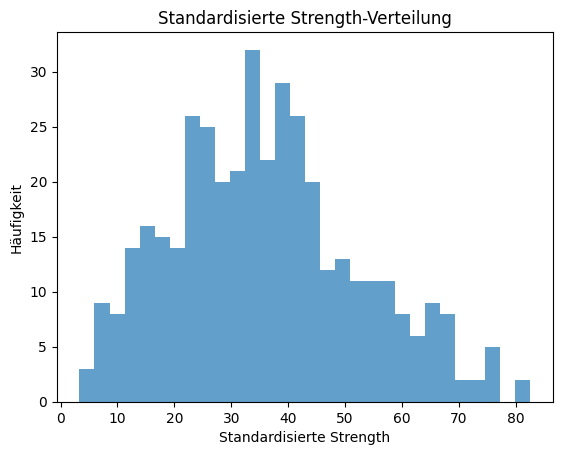

In [25]:
plt.hist(strength, bins=30, alpha=0.7)
plt.title('Standardisierte Strength-Verteilung')
plt.xlabel('Standardisierte Strength')
plt.ylabel('Häufigkeit')
plt.show()

In [30]:
concrete = pd.read_csv('data/concrete.csv')
strength_whole = concrete['strength']

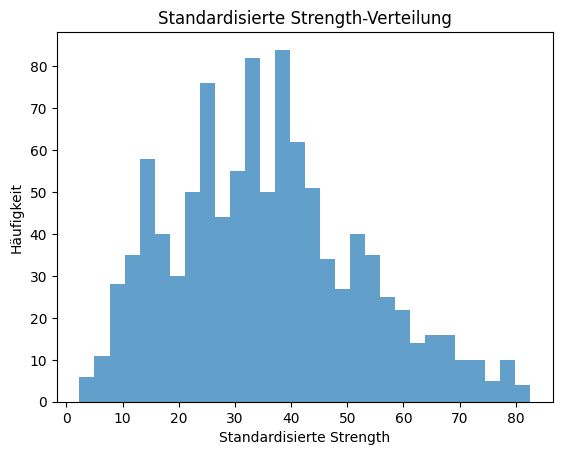

In [31]:
plt.hist(strength_whole, bins=30, alpha=0.7)
plt.title('Standardisierte Strength-Verteilung')
plt.xlabel('Standardisierte Strength')
plt.ylabel('Häufigkeit')
plt.show()

In [ ]:
kde = gaussian_kde(strength)
zufallswerte = kde.resample(100)

In [56]:
print(zufallswerte.ravel())

[10.24888166 52.12723259 66.81803807 38.77349641 31.00695285 42.32964053
 36.51181467 69.49780098 37.93127258 22.34848402 34.49152831  6.55537788
 33.45993827 33.42777945 41.135177   30.51495223 53.69097184 30.06665013
 32.13945341 21.0633681  28.21119794 27.24255793 44.23093567 10.0763167
 34.68624548 44.81394169 61.78752929 66.01600394 15.47354307 20.55693763
 84.68895226 17.84351767 60.58150351 13.43465338 47.59844036 49.187506
 12.90114987 40.00975656 39.33381619 38.20190115 39.11228393  9.76270982
 11.59065407 33.55495623 23.4341088  19.89835236 30.01586448 41.29957021
  6.5513002  20.65817277 33.38611243 68.87158105 50.00314238 32.267982
 15.47553956 48.56608644 18.60016795  8.40017627 37.77990101  4.18192698
 17.49835917 43.48217184 35.3413326  15.02190512 42.32919958 44.60887298
 21.56301818 29.7393049   9.65890095 24.22128399 33.43183094 15.68235628
 67.38177527 42.22347475 40.38187497 33.26270683 20.21856956 38.9786191
 66.16720658  2.81131026 16.01730458 25.20868306 26.45199

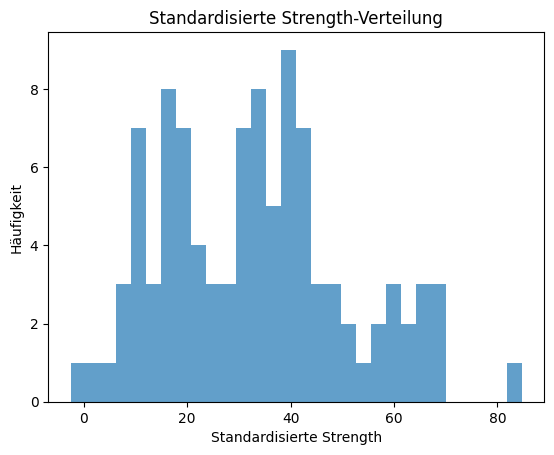

In [59]:
plt.hist(zufallswerte.ravel(), bins=30, alpha=0.7)
plt.title('Standardisierte Strength-Verteilung')
plt.xlabel('Standardisierte Strength')
plt.ylabel('Häufigkeit')
plt.show()

In [ ]:
desired_strength = torch.tensor([[19.77]], dtype=torch.float32)

z = torch.randn(1, 3)

model.eval()
with torch.no_grad():
    generated = model.decode(z, desired_strength)
    generated_original = scaler.inverse_transform(generated.numpy())

print(generated_original)